## Data Load and preprocess

In [1]:
import pandas as pd
import numpy as np

In [35]:
df = pd.read_csv('../data/HI-Small_Trans.csv')

In [36]:
df

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0


In [37]:
print(df['Is Laundering'].value_counts())
print(df['Is Laundering'].value_counts(normalize=True))

0    5073168
1       5177
Name: Is Laundering, dtype: int64
0    0.998981
1    0.001019
Name: Is Laundering, dtype: float64


In [38]:
# randomly select 75000 rows
df = df.sample(n=750000, random_state=1)

In [39]:
print(df['Is Laundering'].value_counts())
print(df['Is Laundering'].value_counts(normalize=True))

0    749214
1       786
Name: Is Laundering, dtype: int64
0    0.998952
1    0.001048
Name: Is Laundering, dtype: float64


In [40]:
X = df.drop(['Is Laundering'], axis=1)
y = df['Is Laundering']

from imblearn.over_sampling import RandomOverSampler

sampling_strategy = 0.05

ros = RandomOverSampler(sampling_strategy=sampling_strategy)

X_resampled, y_resampled = ros.fit_resample(X, y)

In [41]:
y_resampled.value_counts()

0    749214
1     37460
Name: Is Laundering, dtype: int64

In [12]:
X['Timestamp'].sort_values()

92255      2022/09/01 00:00
182059     2022/09/01 00:00
151525     2022/09/01 00:00
276746     2022/09/01 00:00
190694     2022/09/01 00:00
                 ...       
4550063    2022/09/15 13:53
4856096    2022/09/15 16:45
4550069    2022/09/16 00:20
5033962    2022/09/16 12:10
4962231    2022/09/18 11:18
Name: Timestamp, Length: 75000, dtype: object

In [11]:
X['Account'].value_counts()

100428660    2467
1004286A8    1492
100428978     295
1004286F0     276
1004289C0     255
             ... 
805ADBE70       1
80563D160       1
80E95C630       1
8010DFA40       1
80E4385D0       1
Name: Account, Length: 51962, dtype: int64

In [10]:
X['Account.1'].value_counts()

100428660    16
1004286A8     7
812B6D480     6
80E0E0810     6
802E5A840     6
             ..
8137CFBF0     1
8087A3D40     1
80C21CCC0     1
80A5A2C30     1
802277C70     1
Name: Account.1, Length: 62828, dtype: int64

In [9]:
X.isna().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
dtype: int64

no missing values

In [15]:
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
df = df_resampled

### Feature Engineering

In [42]:
df['day'] = pd.to_datetime(df['Timestamp']).dt.day
df['month'] = pd.to_datetime(df['Timestamp']).dt.month
df['year'] = pd.to_datetime(df['Timestamp']).dt.year
df['is_weekend'] = pd.to_datetime(df['Timestamp']).dt.dayofweek.apply(lambda x: 1 if x > 4 else 0)
df['day_of_week'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
df['quarter'] = pd.to_datetime(df['Timestamp']).dt.quarter

In [51]:
import numpy as np

df['log_amount_received'] = df['Amount Received'].apply(lambda x: np.log(x))
df['log_amount_paid'] = df['Amount Paid'].apply(lambda x: np.log(x))

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['scaled_amount_received'] = scaler.fit_transform(df['Amount Received'].values.reshape(-1,1))
df['scaled_amount_paid'] = scaler.fit_transform(df['Amount Paid'].values.reshape(-1,1))

In [52]:
numerical_columns = ['day', 'month', 'year', 'is_weekend', 'day_of_week', 'quarter', 'log_amount_received', 'log_amount_paid', 'scaled_amount_received', 'scaled_amount_paid']
X = df[numerical_columns]
y = df['Is Laundering']

In [53]:
columns_to_one_hot_encode = ['Receiving Currency', 'Payment Currency', 'Payment Format']

# one hot encode the columns in the list above and store the results in a new dataframe
dummies_df = pd.get_dummies(df[columns_to_one_hot_encode], columns=columns_to_one_hot_encode)
X = pd.concat([X, dummies_df], axis=1)

In [54]:
X

,day,month,year,is_weekend,day_of_week,quarter,log_amount_received,log_amount_paid,scaled_amount_received,scaled_amount_paid,...,Payment Currency_US Dollar,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
4205263,8,9,2022,0,3,3,9.488315,9.488315,2.360758e-08,1.109087e-07,...,0,0,0,0,0,1,0,0,0,0
3270156,7,9,2022,0,2,3,5.798911,5.798911,5.898797e-10,2.771263e-09,...,0,0,0,0,0,0,0,1,0,0
2669041,5,9,2022,0,0,3,10.905910,10.905910,9.743281e-08,4.577407e-07,...,0,0,0,0,0,0,0,1,0,0
262487,1,9,2022,0,3,3,8.759487,8.759487,1.139004e-08,5.351055e-08,...,0,0,0,1,0,0,0,0,0,0
2618957,5,9,2022,0,0,3,9.970040,9.970040,3.821744e-08,1.795461e-07,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036926,10,9,2022,1,5,3,15.908247,15.908247,1.449414e-05,6.809366e-05,...,0,1,0,0,0,1,0,0,0,0
3064133,6,9,2022,0,1,3,7.186175,7.186175,2.361807e-09,1.109580e-08,...,0,0,0,1,0,0,0,0,0,0
4153766,8,9,2022,0,3,3,8.470827,8.470827,8.534180e-09,4.009369e-08,...,0,0,1,0,0,0,1,0,0,0
3714801,7,9,2022,0,2,3,10.226504,10.226504,4.939040e-08,2.320368e-07,...,1,0,0,0,0,0,0,1,0,0


In [55]:
columns = X.columns

In [56]:
columns.shape

(47,)

# Train the model

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import torch.optim as optim

In [58]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(47, 24),  # Encode_1: 47 -> 24
            nn.Tanh(),
            nn.Linear(24, 12),  # Encode_2: 24 -> 12
            nn.ReLU(),
            nn.Linear(12, 6),  # Encode_3: 12 -> 6
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),  # Decode_1: 1 -> 2
            nn.Tanh(),
            nn.Linear(12, 24),  # Decode_2: 2 -> 4
            nn.ReLU(),
            nn.Linear(24, 47),  # Decode_3: 4 -> 8
            nn.LeakyReLU()      # Model_Output layer: Producing outputs in [0,1]
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [59]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels, _, test_idx = train_test_split(X, y, X.index, test_size=0.25)

# Filter training data to only include normal transactions
normal_train_data = train_data[train_labels == 0] # Assuming 0 means normal

train_tensor = torch.tensor(normal_train_data.values, dtype=torch.float32)
test_tensor = torch.tensor(test_data.values, dtype=torch.float32)


batch_size = 64
train_dataset = torch.utils.data.TensorDataset(train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
lambda_reg = 1e-3

# Model initialization
model = Autoencoder()

# Choice of loss
loss_type = 'MSE'  # Choose between 'MSE' and 'BCE'
if loss_type == 'MSE':
    criterion = nn.MSELoss()  # Mean squared error loss
else:
    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss. Use if you have a sigmoid activation in the output layer.

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Early stopping setup
best_loss = float('inf')
patience = 10
epochs_without_improvement = 0

# Training loop with early stopping
num_epochs = 100

loss_values = []
test_loss_values = []
reconstruction_errors = []

In [61]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_dataloader:
        inputs = batch[0]

        # Zero the optimizer's gradient buffer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        mse_loss = criterion(outputs, inputs)
        
        # 3. Activity Regularizer
        # Assuming the first layer of the encoder is model.encoder[0]
        activity_regularizer = lambda_reg * torch.norm(model.encoder[0](inputs), 1)
        
        # Combining the regularized loss
        total_loss = mse_loss + activity_regularizer

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    epoch_loss = epoch_loss / len(train_dataloader)

    # Save the loss value for plotting
    loss_values.append(epoch_loss)


    # Test the model
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for batch in test_dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            mse_loss = criterion(outputs, inputs)
            test_loss += mse_loss.item()

            batch_errors = torch.sum((outputs - inputs) ** 2, dim=1).numpy() # Sum of squared differences for each sample
            reconstruction_errors.extend(batch_errors)

        test_loss = test_loss / len(test_dataloader)
        test_loss_values.append(test_loss)

    model.train()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


    # Early stopping check
    if epoch_loss + 1e-5 < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement == patience:
        print("Early stopping due to no improvement in loss.")
        break

Epoch [1/100], Train Loss: 258.9964, Test Loss: 3.0318
Epoch [2/100], Train Loss: 35.3008, Test Loss: 1.7227
Epoch [3/100], Train Loss: 34.3503, Test Loss: 1.5267
Epoch [4/100], Train Loss: 35.6051, Test Loss: 1.2014
Epoch [5/100], Train Loss: 34.7057, Test Loss: 1.1395
Epoch [6/100], Train Loss: 35.9404, Test Loss: 1.1907
Epoch [7/100], Train Loss: 33.4901, Test Loss: 1.1927
Epoch [8/100], Train Loss: 33.1104, Test Loss: 1.0541
Epoch [9/100], Train Loss: 31.3445, Test Loss: 1.3101
Epoch [10/100], Train Loss: 35.7216, Test Loss: 1.1704
Epoch [11/100], Train Loss: 32.3740, Test Loss: 1.3229
Epoch [12/100], Train Loss: 32.8358, Test Loss: 1.0311
Epoch [13/100], Train Loss: 33.4878, Test Loss: 1.2052
Epoch [14/100], Train Loss: 32.7792, Test Loss: 1.0776
Epoch [15/100], Train Loss: 33.8711, Test Loss: 1.0846
Epoch [16/100], Train Loss: 34.7209, Test Loss: 0.9627
Epoch [17/100], Train Loss: 37.4803, Test Loss: 1.6283
Epoch [18/100], Train Loss: 34.1821, Test Loss: 0.9996
Epoch [19/100], Tr

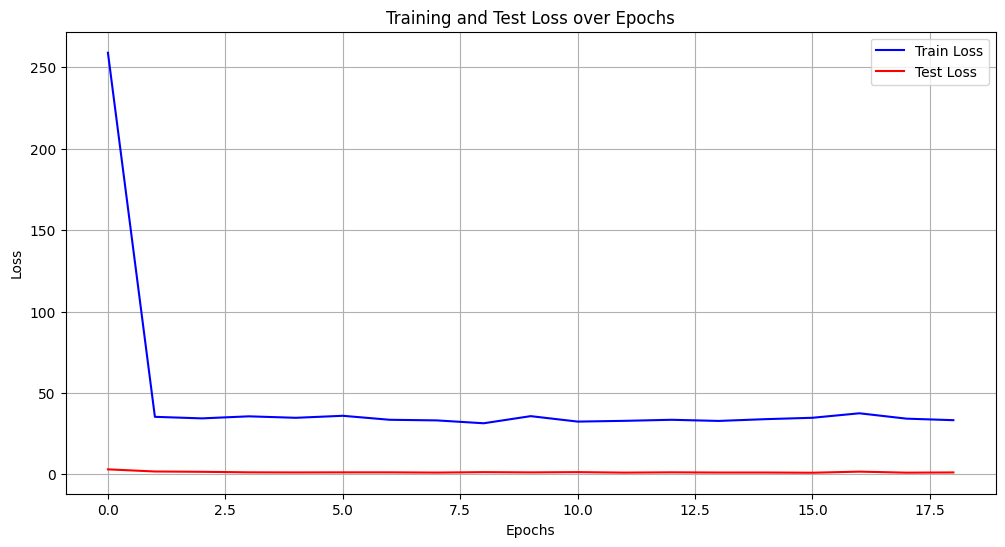

In [62]:
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label="Train Loss", color="blue")
plt.plot(test_loss_values, label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

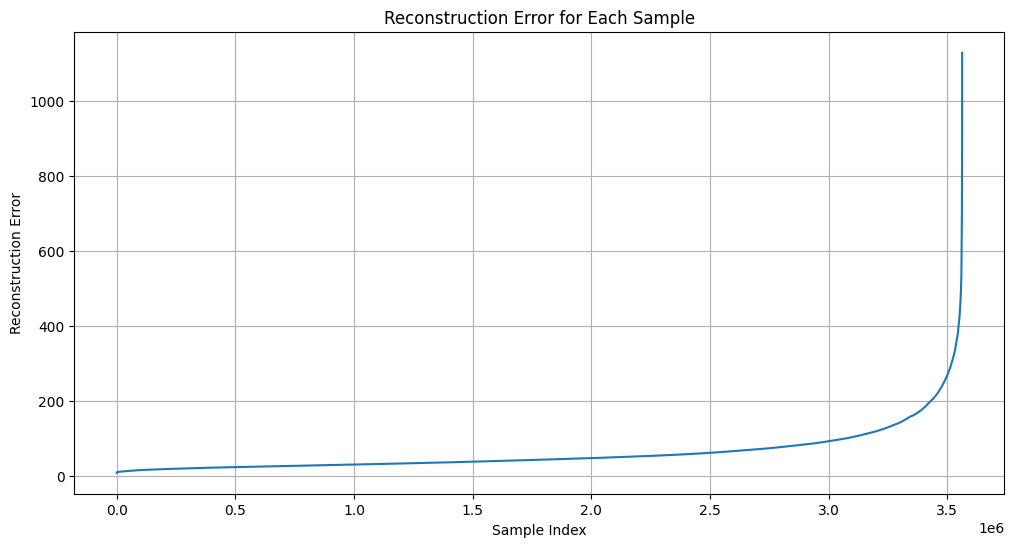

In [63]:
# sort and plot the reconstruction errors
reconstruction_errors.sort()
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors)
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error for Each Sample")
plt.grid(True)

In [64]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

# Reconstruct the test data
with torch.no_grad():
    reconstructed_test = model(test_tensor).numpy()

In [68]:
# Calculate reconstruction error
reconstruction_errors = np.mean(np.power(test_data - reconstructed_test, 2), axis=1)

# Choose a threshold based on domain knowledge, the distribution of reconstruction errors, or via a validation set.
threshold = np.percentile(reconstruction_errors, 98)  # e.g., 99th percentile as threshold. This is a naive approach; refine based on your needs.

# Convert reconstruction errors into binary labels (0 or 1)
predicted_labels = [1 if error > threshold else 0 for error in reconstruction_errors]

# Convert reconstruction errors into probabilities between 0 and 1
predicted_probabilities = (reconstruction_errors - min(reconstruction_errors)) / (max(reconstruction_errors) - min(reconstruction_errors))

# Assuming df has a 'reported' column with true labels
true_labels = df['Is Laundering'].loc[test_data.index].values

In [69]:
# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

F1 Score: 0.0005
Precision: 0.0003
Recall: 0.0054
Accuracy: 0.9790
ROC AUC: 0.4927
False Positive Rate (FPR): 0.0200


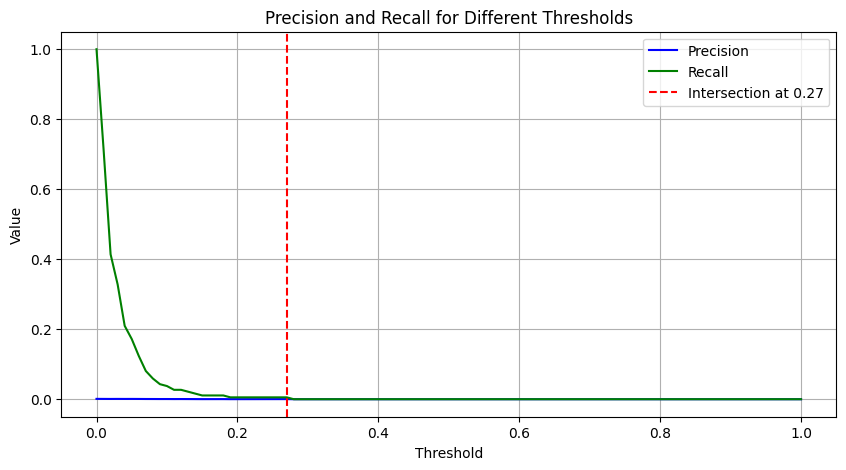

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming the other parts of your code, where you compute `predicted_probabilities` and `true_labels`, are above this

# List to store precision and recall values for each threshold
precisions = []
recalls = []

# Iterate over a range of thresholds (e.g., from 0 to 1 with a step of 0.01)
thresholds = np.arange(0, 1.01, 0.01)  # Adjust the range and step as needed

for threshold in thresholds:
    # Calculate predicted labels for this threshold
    predicted_labels_threshold = [1 if error > threshold else 0 for error in predicted_probabilities]
    
    # Avoiding a scenario where there's a perfect precision or recall which can cause "UndefinedMetricWarning"
    if len(np.unique(predicted_labels_threshold)) > 1:
        # Compute precision and recall
        precision = precision_score(true_labels, predicted_labels_threshold)
        recall = recall_score(true_labels, predicted_labels_threshold)
    else:
        precision, recall = 0, 0

    precisions.append(precision)
    recalls.append(recall)

# Find the threshold where precision and recall cross
diffs = np.array(precisions) - np.array(recalls)
cross_points = np.where(np.diff(np.sign(diffs)))[0]  # Where the difference changes sign

# Plot
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')

# If there's an intersection point, plot it
if len(cross_points) > 0:
    cross_threshold = thresholds[cross_points[0]]
    plt.axvline(x=cross_threshold, color='red', linestyle='--', label=f'Intersection at {cross_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall for Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()
